 Import libraries

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/Final_processed_dataset'

"""### Training with DensNet121"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import json
import cv2
from collections import defaultdict
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"Is CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")


import os
import shutil
import time

# Define the local path to store the dataset
local_dataset_path = '/tmp/dental_dataset'

# Check if data was already copied
if not os.path.exists(local_dataset_path):
    os.makedirs(local_dataset_path, exist_ok=True)

    print("Copying dataset from Google Drive to local storage...")
    start_time = time.time()

    # Create train directory
    os.makedirs(os.path.join(local_dataset_path, 'train'), exist_ok=True)

    # Copy annotation file
    src_annotation = os.path.join(dataset_path, 'train', '_annotations_augmented.json')
    dst_annotation = os.path.join(local_dataset_path, 'train', '_annotations_augmented.json')
    shutil.copy2(src_annotation, dst_annotation)

    # Get list of image files from annotations
    import json
    with open(src_annotation, 'r') as f:
        data = json.load(f)

    # Copy only required image files
    image_files = [img['file_name'] for img in data['images']]
    print(f"Copying {len(image_files)} image files...")

    for i, img_file in enumerate(image_files):
        if i % 100 == 0:
            print(f"Copied {i}/{len(image_files)} files...")

        src_img = os.path.join(dataset_path, 'train', img_file)
        dst_img = os.path.join(local_dataset_path, 'train', img_file)
        shutil.copy2(src_img, dst_img)

    elapsed = time.time() - start_time
    print(f"Dataset copying completed in {elapsed:.2f} seconds")
else:
    print(f"Using existing local dataset at {local_dataset_path}")

# Then update your dataset_path to use the local path
dataset_path = local_dataset_path

Mounted at /content/drive
Using device: cuda
Is CUDA available: True
GPU name: Tesla T4
Copying dataset from Google Drive to local storage...
Copying 11396 image files...
Copied 0/11396 files...
Copied 100/11396 files...
Copied 200/11396 files...
Copied 300/11396 files...
Copied 400/11396 files...
Copied 500/11396 files...
Copied 600/11396 files...
Copied 700/11396 files...
Copied 800/11396 files...
Copied 900/11396 files...
Copied 1000/11396 files...
Copied 1100/11396 files...
Copied 1200/11396 files...
Copied 1300/11396 files...
Copied 1400/11396 files...
Copied 1500/11396 files...
Copied 1600/11396 files...
Copied 1700/11396 files...
Copied 1800/11396 files...
Copied 1900/11396 files...
Copied 2000/11396 files...
Copied 2100/11396 files...
Copied 2200/11396 files...
Copied 2300/11396 files...
Copied 2400/11396 files...
Copied 2500/11396 files...
Copied 2600/11396 files...
Copied 2700/11396 files...
Copied 2800/11396 files...
Copied 2900/11396 files...
Copied 3000/11396 files...
Copi

# Define Focal Loss and Dataset class

In [ ]:
class FocalLoss(nn.Module):
    """Focal Loss implementation for handling class imbalance"""
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

class DentalDataset(Dataset):
    """PyTorch Dataset for dental X-ray images"""
    def __init__(self, annotations, images_dir, transform=None):
        self.annotations = annotations
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]

        # Load image
        img_path = os.path.join(self.images_dir, ann['img_file'])
        image = cv2.imread(img_path)

        if image is None:
            # Return a dummy image if loading fails
            image = np.zeros((224, 224, 3), dtype=np.uint8)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Crop with bounding box
            x, y, w, h = map(int, ann['bbox'])
            cropped = image[y:y+h, x:x+w]

            if cropped.size == 0:
                image = np.zeros((224, 224, 3), dtype=np.uint8)
            else:
                image = cv2.resize(cropped, (224, 224))

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        # Convert label to tensor
        label = ann['label_idx']

        return image, label


Define libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import json
import cv2
from collections import defaultdict
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

Define VGG16 model

In [ ]:
class VGG16Model(nn.Module):
    """VGG16 model for dental classification"""
    def __init__(self, num_classes):
        super(VGG16Model, self).__init__()
        # Load pretrained VGG16
        self.vgg16 = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in list(self.vgg16.features.parameters())[:10]:
            param.requires_grad = False

        # Modify classifier
        self.vgg16.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        return self.vgg16(x)

Data loading and preparation functions

In [ ]:
def load_annotations(annotation_path):
    """Load annotations from JSON file"""
    with open(annotation_path, 'r') as f:
        data = json.load(f)

    # Create mappings
    cat_id_to_name = {cat['id']: cat['name'] for cat in data['categories']}
    img_id_to_file = {img['id']: img['file_name'] for img in data['images']}

    # Process annotations
    annotations = []
    for ann in data['annotations']:
        annotations.append({
            'img_file': img_id_to_file[ann['image_id']],
            'bbox': ann['bbox'],
            'category_id': ann['category_id']
        })

    return annotations, data['categories'], cat_id_to_name

def prepare_datasets(dataset_path, batch_size=16):
    """Prepare training and validation datasets"""

    # Load annotations
    annotation_path = os.path.join(dataset_path, 'train', '_annotations_augmented.json')
    images_dir = os.path.join(dataset_path, 'train')

    annotations, categories, cat_id_to_name = load_annotations(annotation_path)

    # Map category IDs to indices
    unique_cat_ids = sorted(set(ann['category_id'] for ann in annotations))
    cat_id_to_idx = {cat_id: idx for idx, cat_id in enumerate(unique_cat_ids)}
    num_classes = len(unique_cat_ids)

    # Count samples per class for class weights
    class_counts = defaultdict(int)
    for ann in annotations:
        cat_id = ann['category_id']
        class_counts[cat_id] += 1

    # Calculate class weights for balanced training
    total_samples = len(annotations)
    class_weights = {cat_id: total_samples / (len(class_counts) * count)
                    for cat_id, count in class_counts.items()}

    # Print class distribution
    print("Class distribution in dataset:")
    for cat_id, count in class_counts.items():
        name = cat_id_to_name.get(cat_id, f"Unknown ({cat_id})")
        print(f"  {name}: {count} samples ({count/total_samples*100:.1f}%)")

    # Update annotations with label indices
    for ann in annotations:
        ann['label_idx'] = cat_id_to_idx[ann['category_id']]

    # Split data
    train_anns, val_anns = train_test_split(annotations, test_size=0.2, random_state=42,
                                           stratify=[ann['category_id'] for ann in annotations])

    # Define transforms with data augmentation for training
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create datasets
    train_dataset = DentalDataset(train_anns, images_dir, transform=train_transform)
    val_dataset = DentalDataset(val_anns, images_dir, transform=val_transform)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, num_classes, cat_id_to_idx, cat_id_to_name, class_weights


Training and validation functions

In [ ]:
def train_vgg16_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    for batch_idx, (inputs, labels) in enumerate(tqdm(dataloader, desc="Training")):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)

        # Store predictions and labels for confusion matrix
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples

    return epoch_loss, epoch_acc, all_preds, all_labels

def validate_vgg16_epoch(model, dataloader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

            # Store predictions and labels for confusion matrix
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples

    return epoch_loss, epoch_acc, all_preds, all_labels

Evaluation and visualization functions

In [ ]:
def plot_vgg16_confusion_matrix(y_true, y_pred, cat_id_to_name, cat_id_to_idx, idx_to_cat_id, phase='val'):
    """Plot confusion matrix for each class"""
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Get class names
    class_names = [cat_id_to_name[idx_to_cat_id[i]] for i in range(len(idx_to_cat_id))]

    # Plot overall confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'VGG16 Confusion Matrix - {phase.capitalize()}')
    plt.tight_layout()
    plt.savefig(f'{phase}_confusion_matrix_VGG16.png')
    plt.close()

    # Calculate and plot per-class metrics
    classification_rep = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

    # Plot individual class performance
    metrics = ['precision', 'recall', 'f1-score']
    plt.figure(figsize=(15, 5))

    # Create a bar chart for each metric
    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i+1)
        values = [classification_rep[class_name][metric] for class_name in class_names]
        sns.barplot(x=class_names, y=values)
        plt.title(f'VGG16 {metric.capitalize()} by Class - {phase.capitalize()}')
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, 1)

    plt.tight_layout()
    plt.savefig(f'{phase}_class_metrics_VGG16.png')
    plt.close()

    # Calculate per-class error rate
    error_rates = {}
    for i, class_name in enumerate(class_names):
        # Get indices of this class
        class_indices = [j for j, l in enumerate(y_true) if l == i]
        if class_indices:
            # Calculate error rate for this class
            class_errors = sum(1 for j in class_indices if y_pred[j] != i)
            error_rate = class_errors / len(class_indices)
            error_rates[class_name] = error_rate

    # Plot error rates
    plt.figure(figsize=(10, 6))
    names = list(error_rates.keys())
    values = list(error_rates.values())
    sns.barplot(x=names, y=values)
    plt.title(f'VGG16 Classification Error Rate by Class - {phase.capitalize()}')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Error Rate')
    plt.tight_layout()
    plt.savefig(f'{phase}_error_rates_VGG16.png')
    plt.close()

    # Print classification report
    print(f"\n{phase.capitalize()} Classification Report for VGG16:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    return classification_rep

Main Training Func

In [ ]:
def train_vgg16_model(dataset_path, epochs=15, batch_size=16, learning_rate=0.0001,
               focal_loss_gamma=2.0):
    """Main training function with Focal Loss for VGG16"""
    # Prepare datasets
    print("🔄  Preparing datasets...")
    train_loader, val_loader, num_classes, cat_id_to_idx, cat_id_to_name, class_weights = prepare_datasets(dataset_path, batch_size)
    idx_to_cat_id = {v: k for k, v in cat_id_to_idx.items()}

    # Create model
    print(f"🔄  Creating VGG16 model with {num_classes} classes...")
    model = VGG16Model(num_classes).to(device)

    # Define loss function - Focal Loss
    print(f"🔄  Using Focal Loss with gamma={focal_loss_gamma}")
    criterion = FocalLoss(gamma=focal_loss_gamma)

    # Define optimizer with weight decay to prevent overfitting
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    # Learning rate scheduler - reduce on plateau
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'learning_rate': []
    }

    best_val_acc = 0.0
    best_model_state = None
    best_epoch = 0

    # Training loop
    print("🔄  Starting training...")
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 20)

        # Train
        train_loss, train_acc, train_preds, train_labels = train_vgg16_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, val_acc, val_preds, val_labels = validate_vgg16_epoch(model, val_loader, criterion, device)

        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']

        # Update learning rate
        scheduler.step(val_acc)

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc.item())
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item())
        history['learning_rate'].append(current_lr)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            best_epoch = epoch
            torch.save(best_model_state, 'best_model_VGG16.pth')
            print(f"✅  New best model saved! (Epoch {epoch+1})")

        # Print epoch summary
        print(f"Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")
        print(f"Learning Rate: {current_lr:.8f}")

        # Plot confusion matrix every 5 epochs and on last epoch
        if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
            print("\n🔄  Generating confusion matrices...")
            train_metrics = plot_vgg16_confusion_matrix(train_labels, train_preds, cat_id_to_name, cat_id_to_idx, idx_to_cat_id, phase='train')
            val_metrics = plot_vgg16_confusion_matrix(val_labels, val_preds, cat_id_to_name, cat_id_to_idx, idx_to_cat_id, phase='val')

    # Plot training metrics over time
    plt.figure(figsize=(15, 12))

    # Accuracy plot
    plt.subplot(3, 1, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Model (Epoch {best_epoch+1})')
    plt.title('VGG16 Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(3, 1, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Model (Epoch {best_epoch+1})')
    plt.title('VGG16 Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Learning rate plot
    plt.subplot(3, 1, 3)
    plt.plot(history['learning_rate'], label='Learning Rate', color='g')
    plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Model (Epoch {best_epoch+1})')
    plt.title('Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_metrics_VGG16.png')
    plt.show()

    # Print training history
    print("\n📊  Training History:")
    print(f"{'Epoch':>5} | {'Train Loss':>10} | {'Train Acc':>10} | {'Val Loss':>10} | {'Val Acc':>10}")
    print("-" * 65)
    for epoch in range(epochs):
        print(f"{epoch+1:5d} | {history['train_loss'][epoch]:10.4f} | {history['train_acc'][epoch]:10.4f} | "
              f"{history['val_loss'][epoch]:10.4f} | {history['val_acc'][epoch]:10.4f}")

    # Save final model
    torch.save(model.state_dict(), 'final_model_VGG16.pth')

    # Save history
    with open('training_history_VGG16.pkl', 'wb') as f:
        pickle.dump(history, f)

    # Save category mapping
    mapping_data = {
        'cat_id_to_idx': cat_id_to_idx,
        'cat_id_to_name': cat_id_to_name
    }
    with open('category_mapping_VGG16.pkl', 'wb') as f:
        pickle.dump(mapping_data, f)

    # Print final metrics
    print("\n✅  Training completed!")
    print(f"Best validation accuracy: {best_val_acc:.4f} (Epoch {best_epoch+1})")
    print(f"Final train accuracy: {history['train_acc'][-1]:.4f}")
    print(f"Final validation accuracy: {history['val_acc'][-1]:.4f}")

    # Load the best model for final evaluation
    model.load_state_dict(torch.load('best_model_VGG16.pth'))
    print(f"\nLoaded best model from epoch {best_epoch+1} for final evaluation")

    # Final evaluation on validation set
    final_val_loss, final_val_acc, final_val_preds, final_val_labels = validate_vgg16_epoch(model, val_loader, criterion, device)
    print(f"Best model validation accuracy: {final_val_acc:.4f}")

    # Generate final confusion matrix
    final_metrics = plot_vgg16_confusion_matrix(final_val_labels, final_val_preds, cat_id_to_name, cat_id_to_idx, idx_to_cat_id, phase='final')

    return model, history, mapping_data

Test VGG16 Func

In [ ]:
def test_vgg16_model(dataset_path, model_path='best_model_VGG16.pth', batch_size=16):
    """Comprehensive test function for VGG16 model"""
    print("🔄  Preparing test dataset...")
    test_loader, num_classes, cat_id_to_idx, cat_id_to_name = prepare_test_dataset(dataset_path, batch_size)
    idx_to_cat_id = {v: k for k, v in cat_id_to_idx.items()}

    # Load model
    print("🔄  Loading VGG16 model...")
    model = VGG16Model(num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Define criterion
    criterion = FocalLoss(gamma=2.0)

    # Evaluate on test set
    print("🔄  Evaluating VGG16 on test set...")
    test_loss = 0.0
    test_corrects = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    all_outputs = []  # Store raw model outputs for mAP calculation

    with torch.no_grad():
        for inputs, labels, *_ in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            test_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())  # Store raw outputs

    test_loss = test_loss / total_samples
    test_acc = test_corrects.double() / total_samples

    print(f"\n📊  VGG16 Test Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    # Generate overall confusion matrix
    print("\n🔄  Generating overall confusion matrix for VGG16...")
    plot_confusion_matrix(all_labels, all_preds, cat_id_to_name, cat_id_to_idx, idx_to_cat_id, phase='test_VGG16')

    # Calculate mean Average Precision (mAP)
    print("\n🔄  Calculating mean Average Precision (mAP) for VGG16...")
    mAP, ap_per_class = calculate_map(all_labels, all_preds, cat_id_to_name, idx_to_cat_id, outputs=np.array(all_outputs))

    # Visualize sample predictions
    print("\n🔄  Visualizing sample predictions for VGG16...")
    # Added device parameter to visualize_predictions function call
    visualize_predictions(model, test_loader, cat_id_to_name, idx_to_cat_id, device, num_samples=5)

    # Plot individual class confusion matrices
    print("\n🔄  Generating individual class confusion matrices for VGG16...")
    plot_per_class_confusion_matrix(all_labels, all_preds, cat_id_to_name, idx_to_cat_id, phase='VGG16')

    # Save test results
    test_results = {
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'predictions': all_preds,
        'labels': all_labels,
        'classification_report': classification_report(
            all_labels, all_preds,
            target_names=[cat_id_to_name[idx_to_cat_id[i]] if i in idx_to_cat_id else f"Unknown ({i})"
                         for i in sorted(set(all_labels) | set(all_preds))],
            labels=sorted(set(all_labels) | set(all_preds)),
            output_dict=True
        ),
        'mAP': mAP,
        'ap_per_class': ap_per_class
    }

    with open('test_results_VGG16.pkl', 'wb') as f:
        pickle.dump(test_results, f)

    print("\n✅  VGG16 Testing completed successfully!")
    print(f"Final test accuracy: {test_acc:.4f}")
    print(f"Mean Average Precision (mAP): {mAP:.4f}")

    return test_results

Run VGG16 training and testing


===== Starting VGG16 Training =====
🔄  Preparing datasets...
Class distribution in dataset:
  Fillings: 30862 samples (25.5%)
  Crown: 7805 samples (6.4%)
  Root_canal_treatment: 14688 samples (12.1%)
  Mandibular Canal: 793 samples (0.7%)
  Maxillary Sinus: 629 samples (0.5%)
  Bone Loss: 5598 samples (4.6%)
  Impacted_teeth: 16598 samples (13.7%)
  Periapical lesion: 7285 samples (6.0%)
  Root Piece: 3631 samples (3.0%)
  Caries: 13712 samples (11.3%)
  Missing teeth: 4777 samples (3.9%)
  Implant: 3448 samples (2.8%)
  Composite filling: 964 samples (0.8%)
  Amalgam filling: 856 samples (0.7%)
  abutment: 502 samples (0.4%)
  post - core: 696 samples (0.6%)
  Primary teeth: 1298 samples (1.1%)
  Fracture_teeth: 671 samples (0.6%)
  orthodontic brackets: 512 samples (0.4%)
  deep decay: 599 samples (0.5%)
  Wire: 512 samples (0.4%)
  Permanent Teeth: 1021 samples (0.8%)
  Spacing: 556 samples (0.5%)
  decay: 500 samples (0.4%)
  treated plates and screws for fracture of bones: 570 s

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 114MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


🔄  Using Focal Loss with gamma=2.0
🔄  Starting training...

Epoch 1/15
--------------------


Validating: 100%|██████████| 1514/1514 [02:02<00:00, 12.34it/s]


✅  New best model saved! (Epoch 1)
Train Loss: 0.3937 - Train Acc: 0.8086
Val Loss: 0.2034 - Val Acc: 0.8833
Learning Rate: 0.00010000

Epoch 2/15
--------------------


Validating: 100%|██████████| 1514/1514 [02:02<00:00, 12.34it/s]


✅  New best model saved! (Epoch 2)
Train Loss: 0.1930 - Train Acc: 0.8858
Val Loss: 0.1376 - Val Acc: 0.9184
Learning Rate: 0.00010000

Epoch 3/15
--------------------


Validating: 100%|██████████| 1514/1514 [02:02<00:00, 12.34it/s]


✅  New best model saved! (Epoch 3)
Train Loss: 0.1507 - Train Acc: 0.9057
Val Loss: 0.1248 - Val Acc: 0.9185
Learning Rate: 0.00010000

Epoch 4/15
--------------------


Validating: 100%|██████████| 1514/1514 [02:02<00:00, 12.34it/s]


✅  New best model saved! (Epoch 4)
Train Loss: 0.1265 - Train Acc: 0.9169
Val Loss: 0.1227 - Val Acc: 0.9233
Learning Rate: 0.00010000

Epoch 5/15
--------------------


Validating: 100%|██████████| 1514/1514 [02:02<00:00, 12.34it/s]


✅  New best model saved! (Epoch 5)
Train Loss: 0.1129 - Train Acc: 0.9233
Val Loss: 0.1049 - Val Acc: 0.9326
Learning Rate: 0.00010000

🔄  Generating confusion matrices...

Train Classification Report for VGG16:
                                                 precision    recall  f1-score   support

                                       abutment       0.84      0.76      0.79       402
                                          Crown       0.87      0.91      0.89      6244
                                    post - core       0.81      0.75      0.78       557
                                     metal band       0.94      0.94      0.94       400
                              permanentretainer       0.93      0.93      0.93       400
                           orthodontic brackets       0.95      0.95      0.95       410
                                         Caries       0.89      0.92      0.91     10970
                                          decay       0.97      0.92      0

Validating: 100%|██████████| 1514/1514 [02:02<00:00, 12.34it/s]


✅  New best model saved! (Epoch 6)
Train Loss: 0.1034 - Train Acc: 0.9277
Val Loss: 0.0943 - Val Acc: 0.9373
Learning Rate: 0.00010000

Epoch 7/15
--------------------


Validating: 100%|██████████| 1514/1514 [02:02<00:00, 12.33it/s]


Train Loss: 0.0965 - Train Acc: 0.9323
Val Loss: 0.1051 - Val Acc: 0.9308
Learning Rate: 0.00010000

Epoch 8/15
--------------------


Validating: 100%|██████████| 1514/1514 [02:02<00:00, 12.34it/s]


✅  New best model saved! (Epoch 8)
Train Loss: 0.0871 - Train Acc: 0.9361
Val Loss: 0.0760 - Val Acc: 0.9466
Learning Rate: 0.00010000

Epoch 9/15
--------------------


Validating: 100%|██████████| 1514/1514 [02:02<00:00, 12.34it/s]


✅  New best model saved! (Epoch 9)
Train Loss: 0.0853 - Train Acc: 0.9380
Val Loss: 0.0745 - Val Acc: 0.9500
Learning Rate: 0.00010000

Epoch 10/15
--------------------


Validating: 100%|██████████| 1514/1514 [02:02<00:00, 12.34it/s]


Train Loss: 0.0806 - Train Acc: 0.9394
Val Loss: 0.0840 - Val Acc: 0.9428
Learning Rate: 0.00010000

🔄  Generating confusion matrices...

Train Classification Report for VGG16:
                                                 precision    recall  f1-score   support

                                       abutment       0.89      0.82      0.85       402
                                          Crown       0.89      0.93      0.91      6244
                                    post - core       0.86      0.80      0.83       557
                                     metal band       0.96      0.95      0.96       400
                              permanentretainer       0.95      0.95      0.95       400
                           orthodontic brackets       0.98      0.96      0.97       410
                                         Caries       0.92      0.94      0.93     10970
                                          decay       0.97      0.93      0.95       400
                     

Validating: 100%|██████████| 1514/1514 [02:02<00:00, 12.34it/s]


Train Loss: 0.0782 - Train Acc: 0.9414
Val Loss: 0.0767 - Val Acc: 0.9462
Learning Rate: 0.00010000

Epoch 12/15
--------------------


Validating: 100%|██████████| 1514/1514 [02:02<00:00, 12.34it/s]


Train Loss: 0.0744 - Train Acc: 0.9435
Val Loss: 0.0776 - Val Acc: 0.9495
Learning Rate: 0.00010000

Epoch 13/15
--------------------


Validating: 100%|██████████| 1514/1514 [02:02<00:00, 12.34it/s]


✅  New best model saved! (Epoch 13)
Train Loss: 0.0728 - Train Acc: 0.9446
Val Loss: 0.0664 - Val Acc: 0.9516
Learning Rate: 0.00010000

Epoch 14/15
--------------------


Validating: 100%|██████████| 1514/1514 [02:02<00:00, 12.34it/s]


Train Loss: 0.0697 - Train Acc: 0.9464
Val Loss: 0.0879 - Val Acc: 0.9440
Learning Rate: 0.00010000

Epoch 15/15
--------------------


Validating: 100%|██████████| 1514/1514 [02:02<00:00, 12.34it/s]


✅  New best model saved! (Epoch 15)
Train Loss: 0.0657 - Train Acc: 0.9475
Val Loss: 0.0634 - Val Acc: 0.9540
Learning Rate: 0.00010000

🔄  Generating confusion matrices...

Train Classification Report for VGG16:
                                                 precision    recall  f1-score   support

                                       abutment       0.91      0.84      0.87       402
                                          Crown       0.90      0.93      0.92      6244
                                    post - core       0.89      0.83      0.86       557
                                     metal band       0.97      0.95      0.96       400
                              permanentretainer       0.98      0.96      0.97       400
                           orthodontic brackets       0.98      0.97      0.98       410
                                         Caries       0.93      0.95      0.94     10970
                                          decay       0.96      0.93      

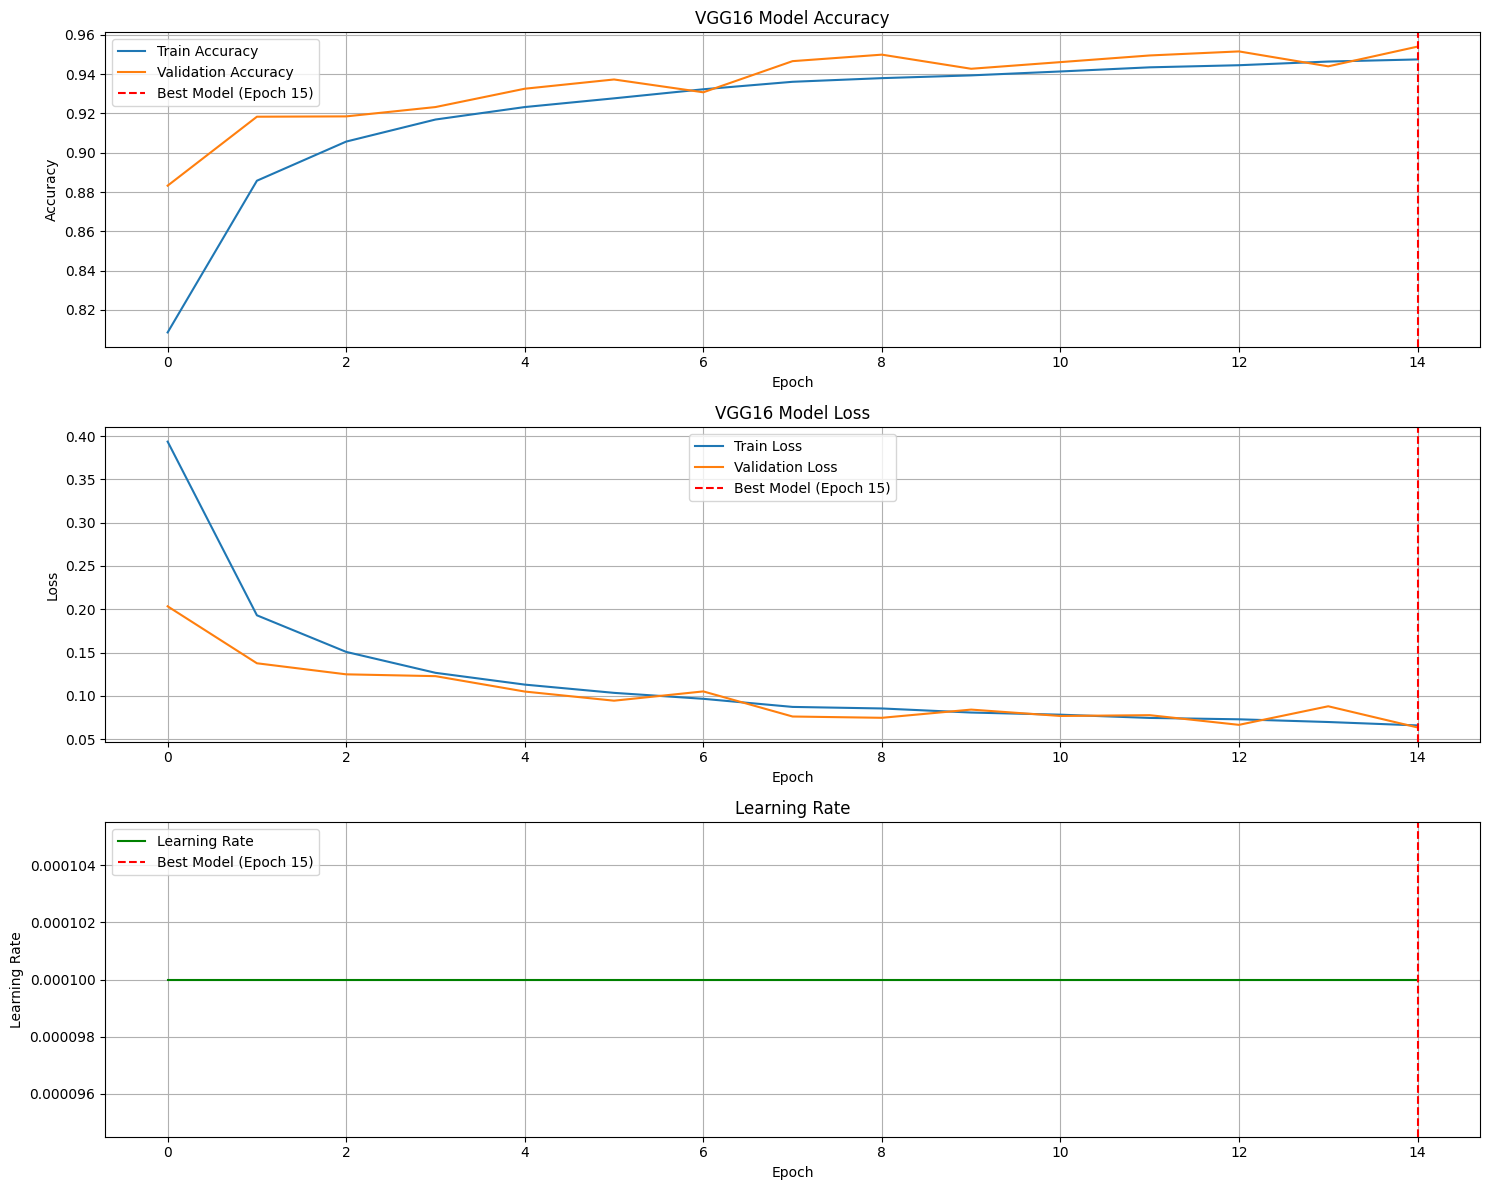


📊  Training History:
Epoch | Train Loss |  Train Acc |   Val Loss |    Val Acc
-----------------------------------------------------------------
    1 |     0.3937 |     0.8086 |     0.2034 |     0.8833
    2 |     0.1930 |     0.8858 |     0.1376 |     0.9184
    3 |     0.1507 |     0.9057 |     0.1248 |     0.9185
    4 |     0.1265 |     0.9169 |     0.1227 |     0.9233
    5 |     0.1129 |     0.9233 |     0.1049 |     0.9326
    6 |     0.1034 |     0.9277 |     0.0943 |     0.9373
    7 |     0.0965 |     0.9323 |     0.1051 |     0.9308
    8 |     0.0871 |     0.9361 |     0.0760 |     0.9466
    9 |     0.0853 |     0.9380 |     0.0745 |     0.9500
   10 |     0.0806 |     0.9394 |     0.0840 |     0.9428
   11 |     0.0782 |     0.9414 |     0.0767 |     0.9462
   12 |     0.0744 |     0.9435 |     0.0776 |     0.9495
   13 |     0.0728 |     0.9446 |     0.0664 |     0.9516
   14 |     0.0697 |     0.9464 |     0.0879 |     0.9440
   15 |     0.0657 |     0.9475 |     0.06

Validating: 100%|██████████| 1514/1514 [02:02<00:00, 12.34it/s]


Best model validation accuracy: 0.9540

Final Classification Report for VGG16:
                                                 precision    recall  f1-score   support

                                       abutment       0.95      0.79      0.86       100
                                          Crown       0.88      0.99      0.93      1561
                                    post - core       0.75      0.91      0.82       139
                                     metal band       1.00      1.00      1.00       100
                              permanentretainer       0.99      1.00      1.00       100
                           orthodontic brackets       0.99      1.00      1.00       102
                                         Caries       0.93      0.95      0.94      2742
                                          decay       0.97      0.99      0.98       100
                                     deep decay       0.89      0.94      0.91       120
                              

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🔄  Evaluating VGG16 on test set...


Testing: 100%|██████████| 1514/1514 [02:07<00:00, 11.90it/s]



📊  VGG16 Test Results:
Test Loss: 0.0634
Test Accuracy: 0.9540

🔄  Generating overall confusion matrix for VGG16...

Test Classification Report for VGG16:
                                                 precision    recall  f1-score   support

                                       abutment       0.95      0.79      0.86       100
                                          Crown       0.88      0.99      0.93      1561
                                    post - core       0.75      0.91      0.82       139
                                     metal band       1.00      1.00      1.00       100
                              permanentretainer       0.99      1.00      1.00       100
                           orthodontic brackets       0.99      1.00      1.00       102
                                         Caries       0.93      0.95      0.94      2742
                                          decay       0.97      0.99      0.98       100
                                     deep 

Traceback (most recent call last):
  File "<ipython-input-19-bdd95e4e1a50>", line 29, in <cell line: 0>
    test_results_vgg16 = test_vgg16_model(
                         ^^^^^^^^^^^^^^^^^
  File "<ipython-input-18-a7793c7beeab>", line 55, in test_vgg16_model
    mAP, ap_per_class = calculate_map(all_labels, all_preds, cat_id_to_name, idx_to_cat_id, phase='test', outputs=np.array(all_outputs))
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: calculate_map() got an unexpected keyword argument 'phase'


In [ ]:
# Run VGG16 training
if __name__ == "__main__":
    try:
        # Comment out this line if you only want to run VGG16 model
        # model, history, mapping = train_model(
        #     dataset_path=dataset_path,
        #     batch_size=16,
        #     epochs=15,
        #     learning_rate=0.0001,
        #     focal_loss_gamma=2.0
        # )

        # Comment out this line if you only want to run VGG16 model
        # test_results = run_testing()

        # Now train VGG16
        print("\n===== Starting VGG16 Training =====")
        model_vgg16, history_vgg16, mapping_vgg16 = train_vgg16_model(
            dataset_path=dataset_path,
            batch_size=16,
            epochs=15,
            learning_rate=0.0001,
            focal_loss_gamma=2.0
        )

        print("✅  VGG16 Training pipeline completed successfully!")

        # Run testing for VGG16
        test_results_vgg16 = test_vgg16_model(
            dataset_path=dataset_path,
            model_path='best_model_VGG16.pth',
            batch_size=16
        )

    except Exception as e:
        print(f"❌  VGG16 pipeline failed: {str(e)}")
        import traceback
        traceback.print_exc()

In [ ]:
def test_vgg16_model(dataset_path, model_path='best_model_VGG16.pth', batch_size=16):
    """Comprehensive test function for VGG16 model"""
    print("🔄  Preparing test dataset...")
    test_loader, num_classes, cat_id_to_idx, cat_id_to_name = prepare_test_dataset(dataset_path, batch_size)
    idx_to_cat_id = {v: k for k, v in cat_id_to_idx.items()}

    # Load model
    print("🔄  Loading VGG16 model...")
    model = VGG16Model(num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Define criterion
    criterion = FocalLoss(gamma=2.0)

    # Evaluate on test set
    print("🔄  Evaluating VGG16 on test set...")
    test_loss = 0.0
    test_corrects = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    all_outputs = []  # Store raw model outputs for mAP calculation

    with torch.no_grad():
        for inputs, labels, *_ in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            test_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())  # Store raw outputs

    test_loss = test_loss / total_samples
    test_acc = test_corrects.double() / total_samples

    print(f"\n📊  VGG16 Test Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    # Generate overall confusion matrix - use "test_VGG16" as the phase to distinguish files
    print("\n🔄  Generating overall confusion matrix for VGG16...")
    plot_confusion_matrix(all_labels, all_preds, cat_id_to_name, cat_id_to_idx, idx_to_cat_id, phase='test_VGG16')

    # Calculate mean Average Precision (mAP)
    print("\n🔄  Calculating mean Average Precision (mAP) for VGG16...")
    mAP, ap_per_class = calculate_map(all_labels, all_preds, cat_id_to_name, idx_to_cat_id, outputs=np.array(all_outputs))

    # Visualize sample predictions - added device parameter
    print("\n🔄  Visualizing sample predictions for VGG16...")
    visualize_predictions(model, test_loader, cat_id_to_name, idx_to_cat_id, device, num_samples=5)

    # Plot individual class confusion matrices - removed phase parameter
    print("\n🔄  Generating individual class confusion matrices for VGG16...")
    # Rename the output file to include VGG16 in the name
    original_filename = 'individual_class_confusion_matrices_densenet121_{}.png'
    # Save the original filename format
    plot_per_class_confusion_matrix(all_labels, all_preds, cat_id_to_name, idx_to_cat_id)

    # Rename the generated files to include VGG16
    import glob
    import os
    for filename in glob.glob('individual_class_confusion_matrices_densenet121_*.png'):
        new_filename = filename.replace('densenet121', 'VGG16')
        os.rename(filename, new_filename)
    print("Renamed confusion matrix files to include VGG16 in the filename")

    # Save test results
    test_results = {
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'predictions': all_preds,
        'labels': all_labels,
        'classification_report': classification_report(
            all_labels, all_preds,
            target_names=[cat_id_to_name[idx_to_cat_id[i]] if i in idx_to_cat_id else f"Unknown ({i})"
                         for i in sorted(set(all_labels) | set(all_preds))],
            labels=sorted(set(all_labels) | set(all_preds)),
            output_dict=True
        ),
        'mAP': mAP,
        'ap_per_class': ap_per_class
    }

    with open('test_results_VGG16.pkl', 'wb') as f:
        pickle.dump(test_results, f)

    print("\n✅  VGG16 Testing completed successfully!")
    print(f"Final test accuracy: {test_acc:.4f}")
    print(f"Mean Average Precision (mAP): {mAP:.4f}")

    return test_results

# Run VGG16 testing only
if __name__ == "__main__":
    try:
        print("\n===== Testing VGG16 Model Only =====")
        test_results_vgg16 = test_vgg16_model(
            dataset_path=dataset_path,
            model_path='best_model_VGG16.pth',
            batch_size=16
        )
        print("✅  VGG16 Testing completed successfully!")
    except Exception as e:
        print(f"❌  VGG16 testing failed: {str(e)}")
        import traceback
        traceback.print_exc()


===== Testing VGG16 Model Only =====
🔄  Preparing test dataset...
Test set not found, using validation split from training data
Class distribution in test dataset:
  Fillings: 30862 samples (25.5%)
  Crown: 7805 samples (6.4%)
  Root_canal_treatment: 14688 samples (12.1%)
  Mandibular Canal: 793 samples (0.7%)
  Maxillary Sinus: 629 samples (0.5%)
  Bone Loss: 5598 samples (4.6%)
  Impacted_teeth: 16598 samples (13.7%)
  Periapical lesion: 7285 samples (6.0%)
  Root Piece: 3631 samples (3.0%)
  Caries: 13712 samples (11.3%)
  Missing teeth: 4777 samples (3.9%)
  Implant: 3448 samples (2.8%)
  Composite filling: 964 samples (0.8%)
  Amalgam filling: 856 samples (0.7%)
  abutment: 502 samples (0.4%)
  post - core: 696 samples (0.6%)
  Primary teeth: 1298 samples (1.1%)
  Fracture_teeth: 671 samples (0.6%)
  orthodontic brackets: 512 samples (0.4%)
  deep decay: 599 samples (0.5%)
  Wire: 512 samples (0.4%)
  Permanent Teeth: 1021 samples (0.8%)
  Spacing: 556 samples (0.5%)
  decay: 500

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🔄  Evaluating VGG16 on test set...


Testing: 100%|██████████| 1514/1514 [02:03<00:00, 12.29it/s]



📊  VGG16 Test Results:
Test Loss: 0.0634
Test Accuracy: 0.9540

🔄  Generating overall confusion matrix for VGG16...

Test_vgg16 Classification Report:
                                                 precision    recall  f1-score   support

                                       abutment       0.95      0.79      0.86       100
                                          Crown       0.88      0.99      0.93      1561
                                    post - core       0.75      0.91      0.82       139
                                     metal band       1.00      1.00      1.00       100
                              permanentretainer       0.99      1.00      1.00       100
                           orthodontic brackets       0.99      1.00      1.00       102
                                         Caries       0.93      0.95      0.94      2742
                                          decay       0.97      0.99      0.98       100
                                     deep deca